In [1]:
# 필요한 package 불러오기

%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.metrics import DistanceMetric
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

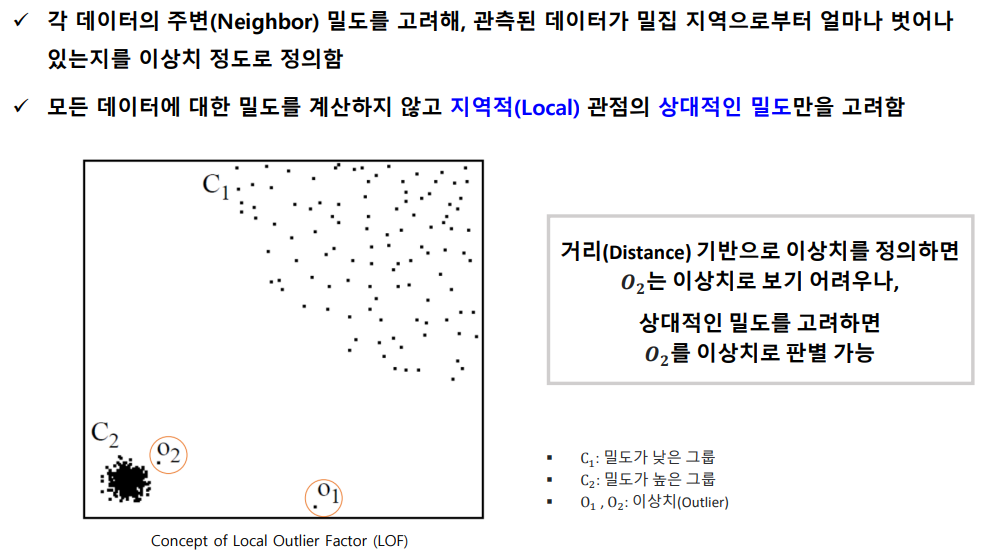

# **1. LOF Algorithm (mathematical approach)**

In [2]:
# Gnerated dataset

np.random.seed(2)

dim = 2 # number of dimensions of dataset = 2

# cluster of normal random variable moderately dense
data1 = np.random.multivariate_normal([0, 1500], [[100000, 0], [0, 100000]], 2000) # mean, cov, number of samples

# very dense
data2 = np.random.multivariate_normal([2000, 0], [[10000, 0], [0, 10000]], 2500)

# sparse
data3 = np.random.multivariate_normal([2500, 2500], [[100000, 0], [0, 100000]], 500)

# mix the three dataset and shuffle
data = np.vstack((np.vstack((data1, data2)), data3))
np.random.shuffle(data)

# add some noise : zipf is skewed distribution and can have extreme values(outliers)
zipf_alpha = 2.25 # distribution parameter (should be greater than 1)
noise = np.random.zipf(zipf_alpha, (5000,dim)) * np.sign((np.random.randint(2, size = (5000, dim)) - 0.5)) # zeta distribution / randint: 정수 난수 생성
data += noise

data.shape

(5000, 2)

> Distance 정의

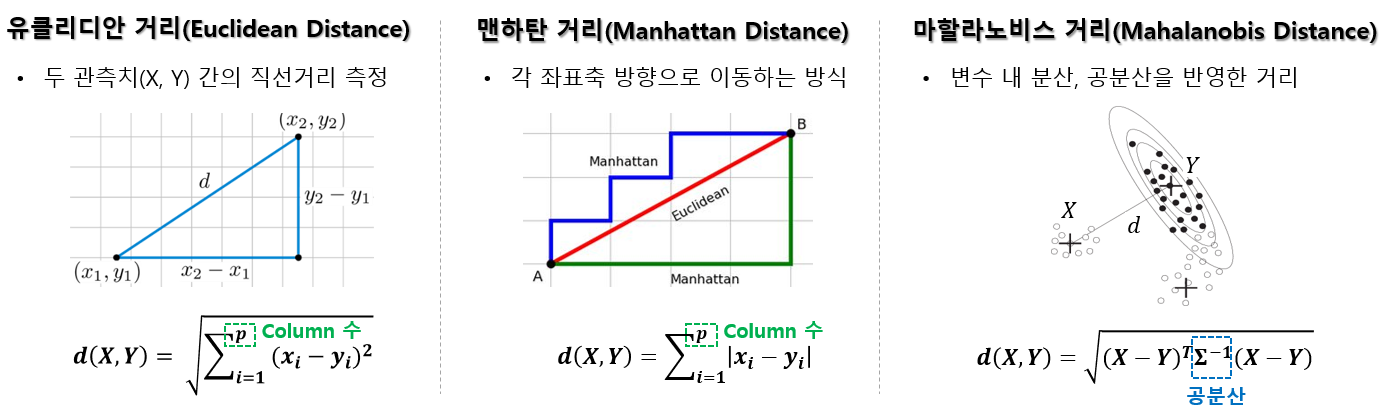

In [3]:
 # distance between points (Euclidean)
tic = time.time()
dist = DistanceMetric.get_metric('euclidean').pairwise(data)

print('++ took %g msecs for Distance computation' %  ((time.time() - tic)* 1000))

++ took 96.0722 msecs for Distance computation


In [4]:
# dist: 총 5000개 samples 간의 거리 계산
dist.shape

(5000, 5000)

> Radius

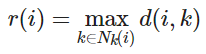

In [5]:
# number of neighbors to consider for distance
k = 17

# get the radius for each point in dataset (distance to kth nearest neighbor)
# radius is the distance of kth nearest point for each point in dataset
tic = time.time()
idx_knn = np.argsort(dist, axis=1)[:,1 : k + 1] # by row' get k nearest neighbour
radius = np.linalg.norm(data - data[idx_knn[:, -1]], axis = 1) # 1-norm

print('+++ took %g msecs for KNN Querying' %  ((time.time() - tic)* 1000))

+++ took 1069.73 msecs for KNN Querying


In [6]:
radius

array([52.53851961, 28.08261004, 22.55848815, ..., 12.93692865,
       48.51320503, 44.8090923 ])

In [7]:
print(idx_knn.shape)
print(radius.shape)

(5000, 17)
(5000,)


> Reach distance (rd) & Local Reachability Distance (LRD)

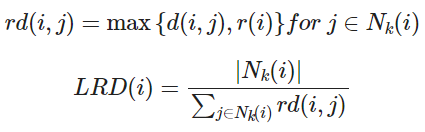

In [8]:
# calculate the local reachability density
tic = time.time()

LRD = []
for i in range(idx_knn.shape[0]):
    LRD.append(np.mean(np.maximum(dist[i, idx_knn[i]], radius[idx_knn[i]])))

print('++++ took %g msecs for LRD computation' %  ((time.time() - tic)* 1000))

++++ took 18.7604 msecs for LRD computation


In [9]:
LRD[:5]

[55.949633023266294,
 26.438563741309263,
 23.36944503654888,
 17.144816315832262,
 19.49672777793099]

In [10]:
print(len(LRD))

5000


> Local Outlier Factor (LOF)

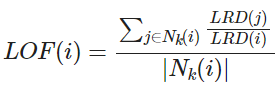

In [11]:
# calculating the outlier score
tic = time.time()

rho = 1. / np.array(LRD) # inverse of density

outlier_score = np.sum(rho[idx_knn], axis = 1)/ np.array(rho, dtype = np.float16)
outlier_score *= 1./k

print('+++++ took %g msecs for Outlier scoring' %  ((time.time() - tic)* 1000))

+++++ took 0.783443 msecs for Outlier scoring


In [12]:
outlier_score

array([0.99184481, 1.03122308, 1.01774952, ..., 1.00576344, 0.98053696,
       1.04538116])

In [13]:
print(outlier_score.shape)

(5000,)


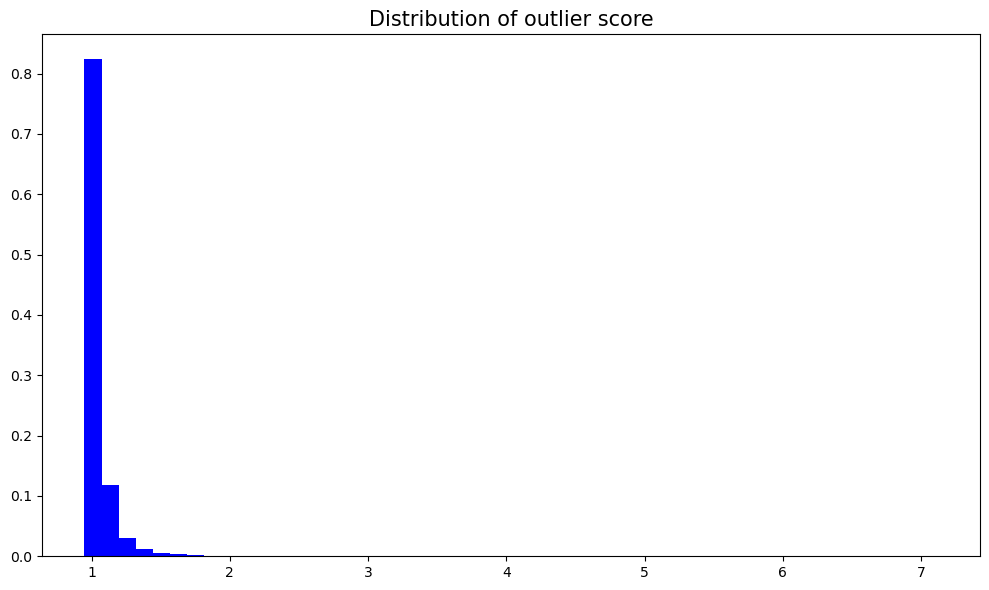

In [14]:
'''
# the histogram of Outlier score, to choose the optimal threshold to decid weather a data-point is outlier is not.
# the optimal outlier score threshold to decide weather a data-point is outlier is outlier or not is around 2 for most of the cases
'''
# to normalize the histogram to probability plot
weights = np.ones_like(outlier_score)/outlier_score.shape[0]

# visualize
plt.figure(figsize = (10, 6))
plt.hist(outlier_score, bins = 50, weights = weights, color = 'b')
plt.title('Distribution of outlier score', fontsize = 15)
plt.tight_layout()
plt.show()

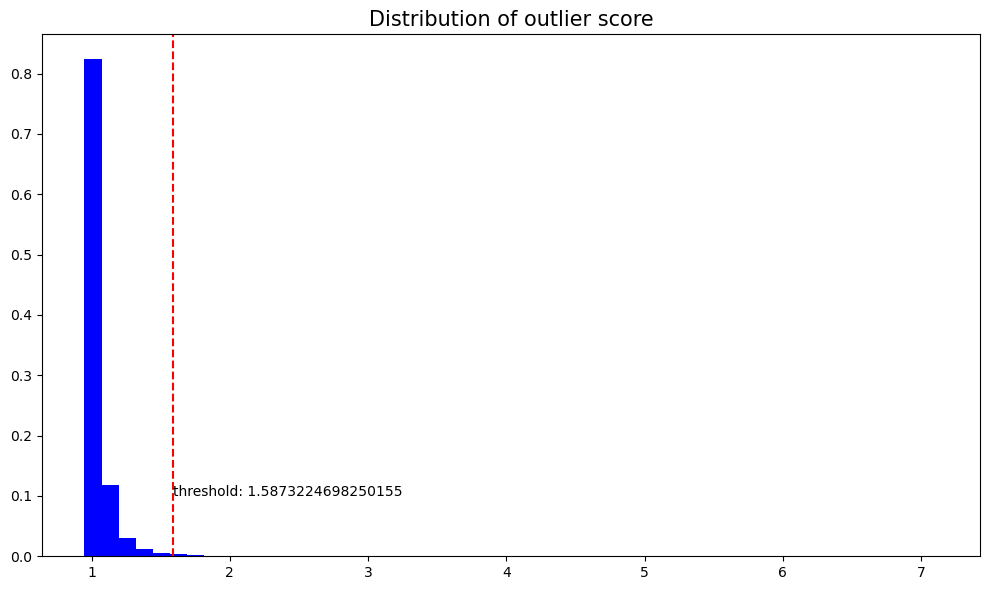

In [15]:
# threshold setting (99% percentile)
threshold = np.percentile(outlier_score, 99)

# visualize
plt.figure(figsize = (10, 6))
plt.hist(outlier_score, bins = 50, weights = weights, color = 'b')
plt.axvline(threshold, linestyle = '--', color = 'r')
plt.text(threshold, 0.1, "threshold: " + str(threshold))
plt.title('Distribution of outlier score', fontsize = 15)
plt.tight_layout()
plt.show()

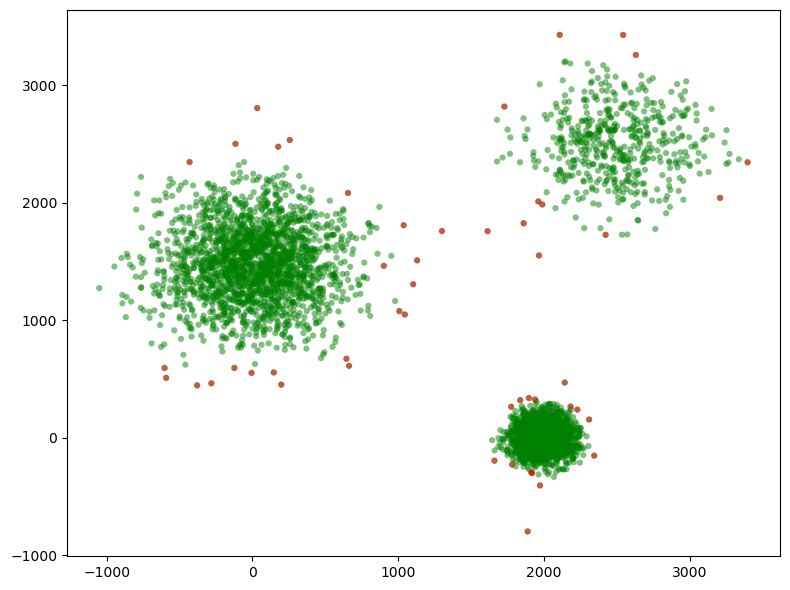

In [16]:
# plot non outliers as green
plt.figure(figsize = (8, 6))
plt.scatter(data[:, 0], data[:, 1], c = 'green', s = 20, edgecolors='None', alpha=0.5)

# find the outliers and plot te outliers
idx = np.where(outlier_score > threshold)
plt.scatter(data[idx, 0], data[idx, 1], c = 'red', s = 20, edgecolors='None', alpha=0.5)
plt.tight_layout()
plt.show()

# **2. LOF Comparison with DBSCAN, GMM, and k-means**

  * DBSCAN은 전체 데이터에서 밀도 낮은 지점을 탐지하는 반면, LOF는 로컬 영역에서의 밀도 낮은 지점을 탐지 가능

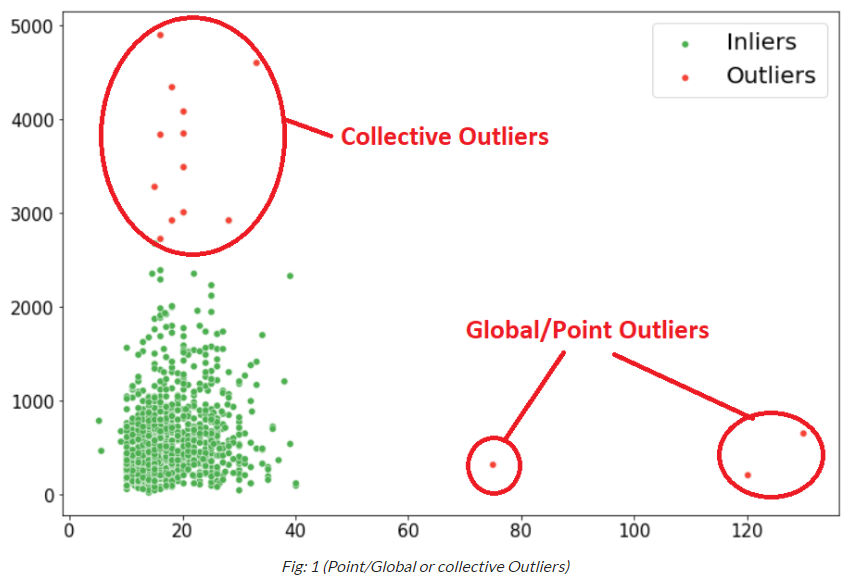

 * k means clustering은 k개의 인접 값을 기반으로 클래스를 할당하며 군집 수를 k로 지정해야 한다는 특성 존재

 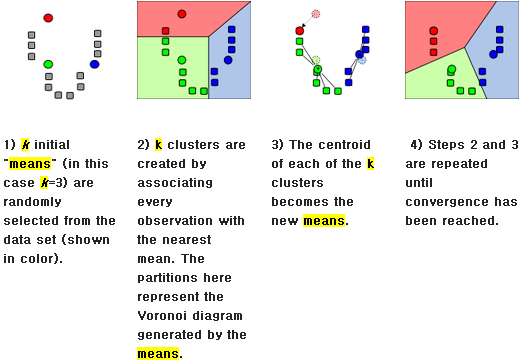

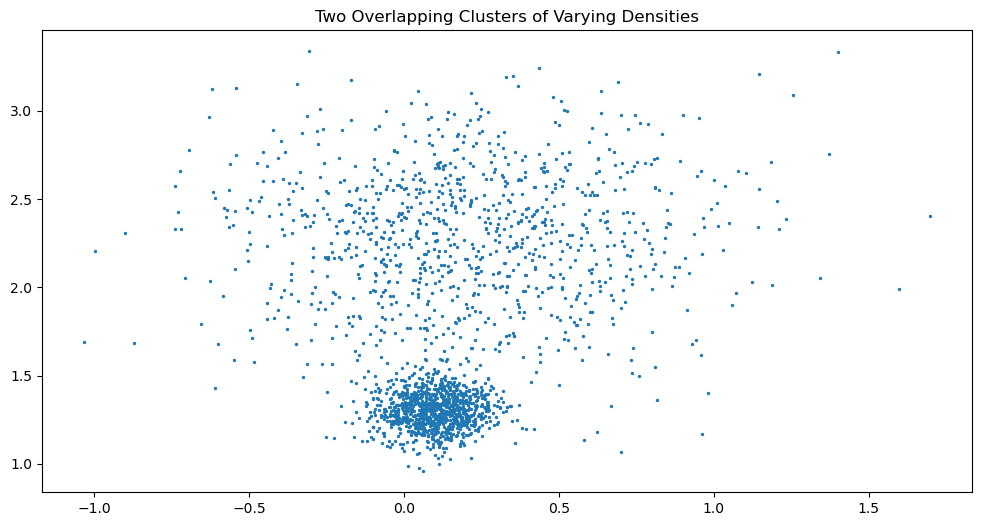

In [17]:
# data generation
blob_centers = np.array(
    [[ 0.2,  2.3],
     [0.1,  1.3]])

blob_std = np.array([0.4, 0.1])

X1, y1 = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

plt.figure(figsize=(12, 6))
plt.title("Two Overlapping Clusters of Varying Densities")
plt.scatter(X1[:, 0], X1[:, 1], s=2);
plt.show()

Cluster IDs:  [-1  0  1]


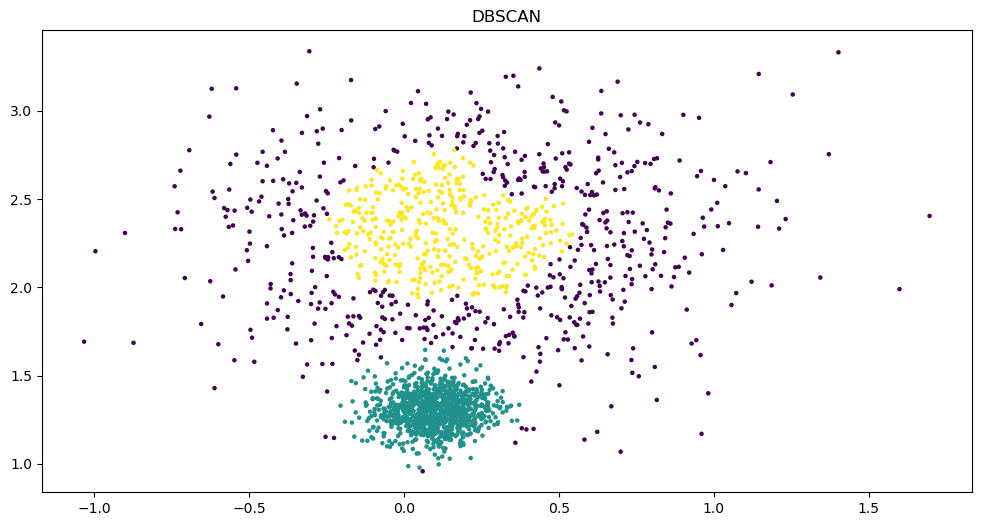

In [18]:
# Train the DBSCAN model
dbscan1 = DBSCAN(eps=0.08, min_samples=17)
dbscan1.fit(X1)

print("Cluster IDs: ", np.unique(dbscan1.labels_))

# visualize the DBSCAN result
plt.figure(figsize=(12, 6))
plt.title("DBSCAN")
plt.scatter(X1[:, 0], X1[:, 1], c=dbscan1.labels_, s=5, cmap='viridis')
plt.show()

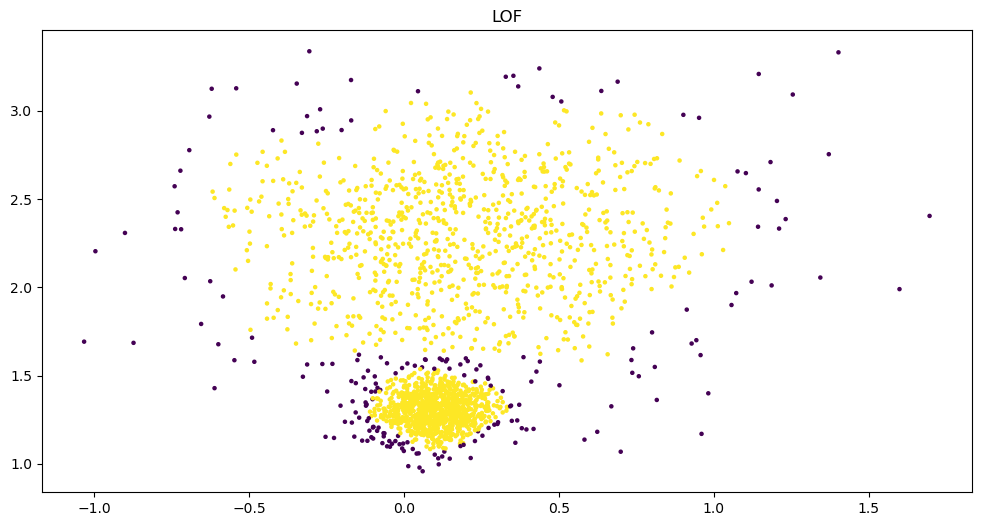

In [19]:
# Train the LOF model
'''
LOF parameter
  - n_neighbors: Number of neighbors
  - metric: Metric to use for distance computation (default is minkowski, which results in the standard Euclidean distance when p=2)
  - contamination: the proportion of outliers
'''
lof = LocalOutlierFactor(n_neighbors=40, metric='minkowski', p=2, contamination=0.1)

# visualize the LOF result
plt.figure(figsize=(12, 6))
plt.title("LOF")
plt.scatter(X1[:, 0], X1[:, 1], c=lof.fit_predict(X1), s=5, cmap='viridis')
plt.show()

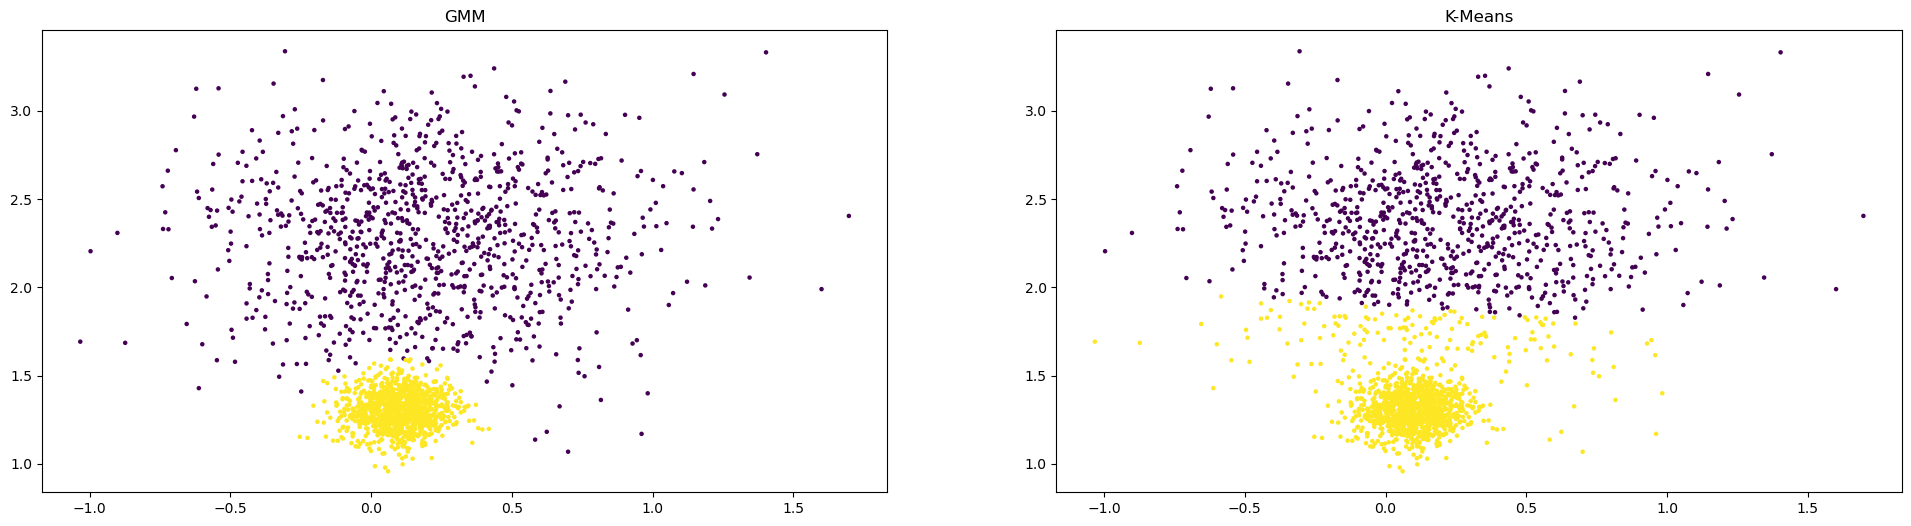

In [20]:
# Train the GMM
gmm1=GaussianMixture(n_components=2, n_init=10, random_state=42)
gmm1.fit(X1)

# Train the K-Means model
kmeans1=KMeans(n_clusters=2, random_state=42)
kmeans1.fit(X1)

# visualize the GMM result
plt.figure(figsize=(24, 6))
plt.subplot(121)
plt.title("GMM")
plt.scatter(X1[:, 0], X1[:, 1], c=gmm1.predict(X1), s=5, cmap='viridis')

# visualize the k-means result
plt.subplot(122)
plt.title("K-Means")
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans1.fit_predict(X1), s=5, cmap='viridis')
plt.show()